In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, Normalizer, OrdinalEncoder, scale
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_selector
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

sns.set_theme(style="darkgrid")

C:\Users\matys\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## Importing data

In [2]:
file_name = 'heart_2020_cleaned.csv'
df = pd.read_csv(file_name)
df.head(10)

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,16.60,Yes,No,No,3.0,30.0,No,Female,55-59,White,Yes,Yes,Very good,5.0,Yes,No,Yes
1,No,20.34,No,No,Yes,0.0,0.0,No,Female,80 or older,White,No,Yes,Very good,7.0,No,No,No
2,No,26.58,Yes,No,No,20.0,30.0,No,Male,65-69,White,Yes,Yes,Fair,8.0,Yes,No,No
3,No,24.21,No,No,No,0.0,0.0,No,Female,75-79,White,No,No,Good,6.0,No,No,Yes
4,No,23.71,No,No,No,28.0,0.0,Yes,Female,40-44,White,No,Yes,Very good,8.0,No,No,No
5,Yes,28.87,Yes,No,No,6.0,0.0,Yes,Female,75-79,Black,No,No,Fair,12.0,No,No,No
6,No,21.63,No,No,No,15.0,0.0,No,Female,70-74,White,No,Yes,Fair,4.0,Yes,No,Yes
7,No,31.64,Yes,No,No,5.0,0.0,Yes,Female,80 or older,White,Yes,No,Good,9.0,Yes,No,No
8,No,26.45,No,No,No,0.0,0.0,No,Female,80 or older,White,"No, borderline diabetes",No,Fair,5.0,No,Yes,No
9,No,40.69,No,No,No,0.0,0.0,Yes,Male,65-69,White,No,Yes,Good,10.0,No,No,No


## Plotting and some changes

In [3]:
df.isnull().sum()

HeartDisease        0
BMI                 0
Smoking             0
AlcoholDrinking     0
Stroke              0
PhysicalHealth      0
MentalHealth        0
DiffWalking         0
Sex                 0
AgeCategory         0
Race                0
Diabetic            0
PhysicalActivity    0
GenHealth           0
SleepTime           0
Asthma              0
KidneyDisease       0
SkinCancer          0
dtype: int64

In [4]:
df.dtypes

HeartDisease         object
BMI                 float64
Smoking              object
AlcoholDrinking      object
Stroke               object
PhysicalHealth      float64
MentalHealth        float64
DiffWalking          object
Sex                  object
AgeCategory          object
Race                 object
Diabetic             object
PhysicalActivity     object
GenHealth            object
SleepTime           float64
Asthma               object
KidneyDisease        object
SkinCancer           object
dtype: object

### Let's see how categorical variables look like

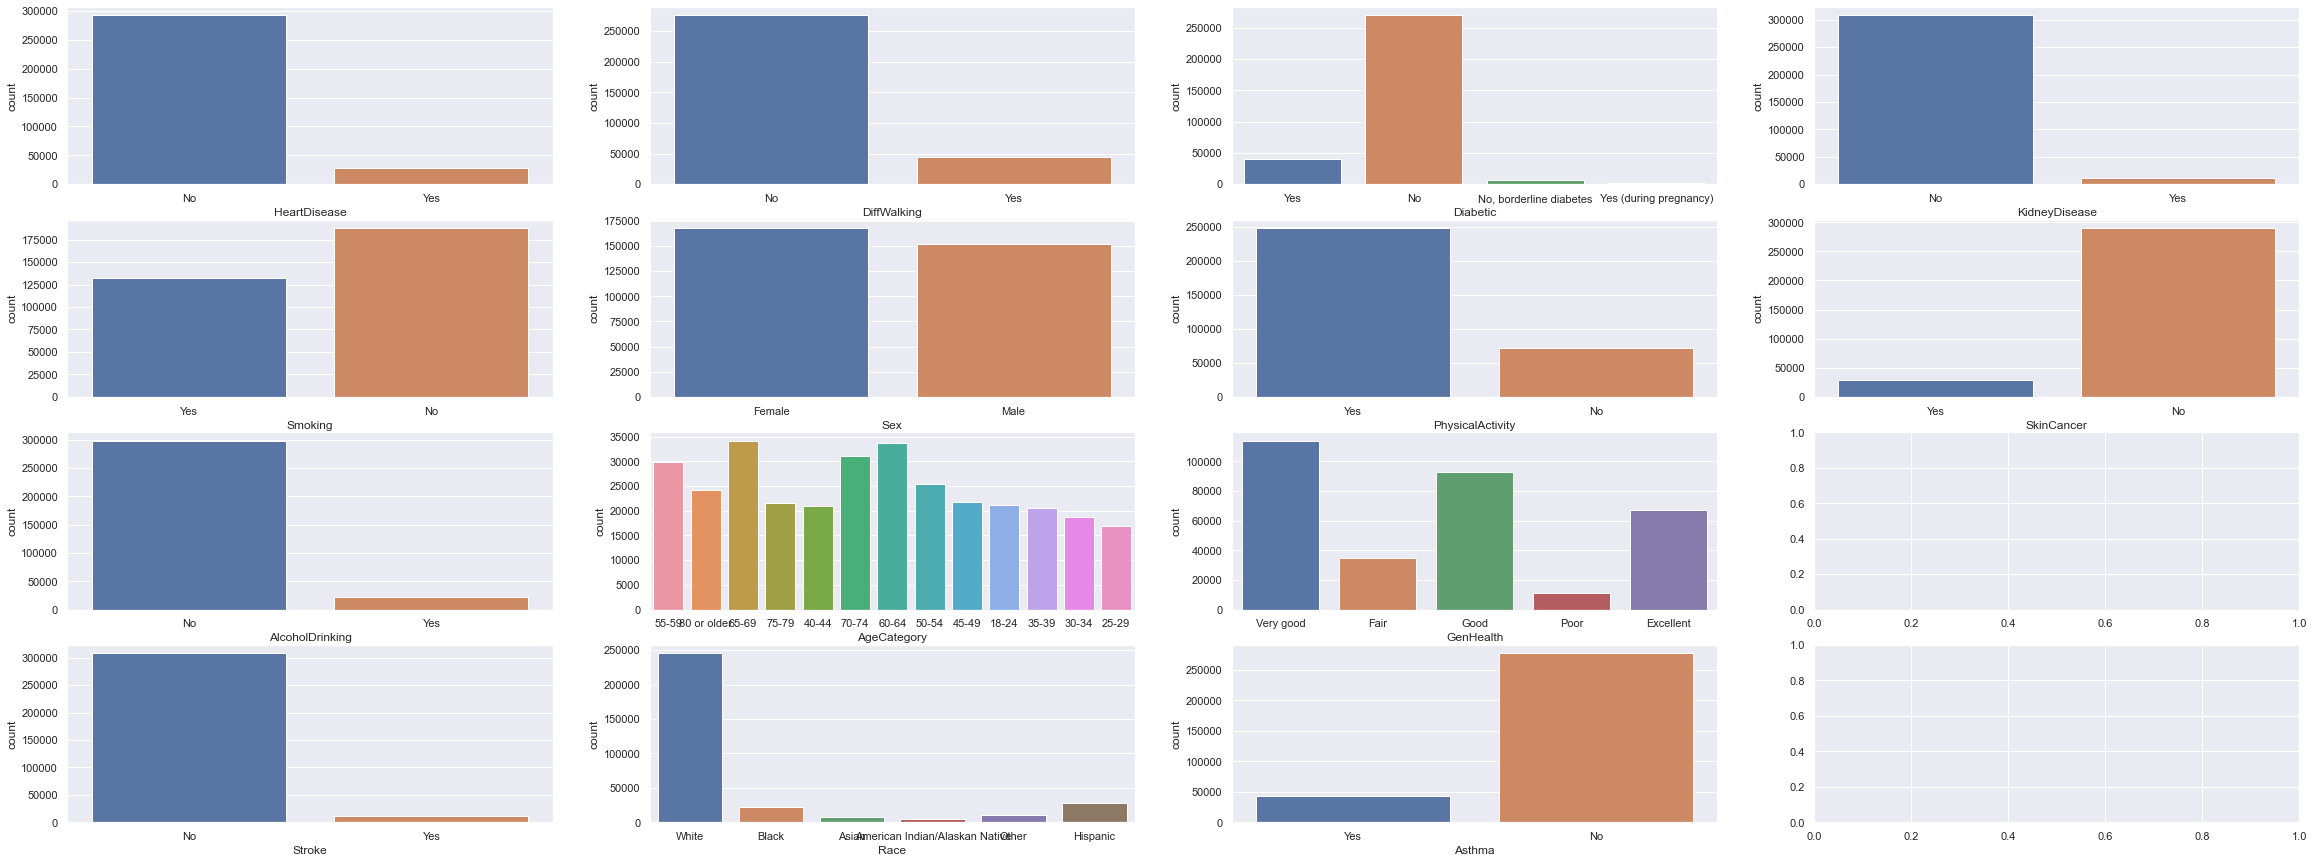

In [5]:
fig, axs = plt.subplots(4, 4, figsize=(40, 15))
numerical = df.select_dtypes(include=np.number)
i, j = 0, 0

for trait in df.columns:
    if trait not in numerical:
        if i == 4:
            i = 0
            j += 1

        sns.countplot(ax = axs[i][j], data=df, x=trait)
        i += 1

plt.show()

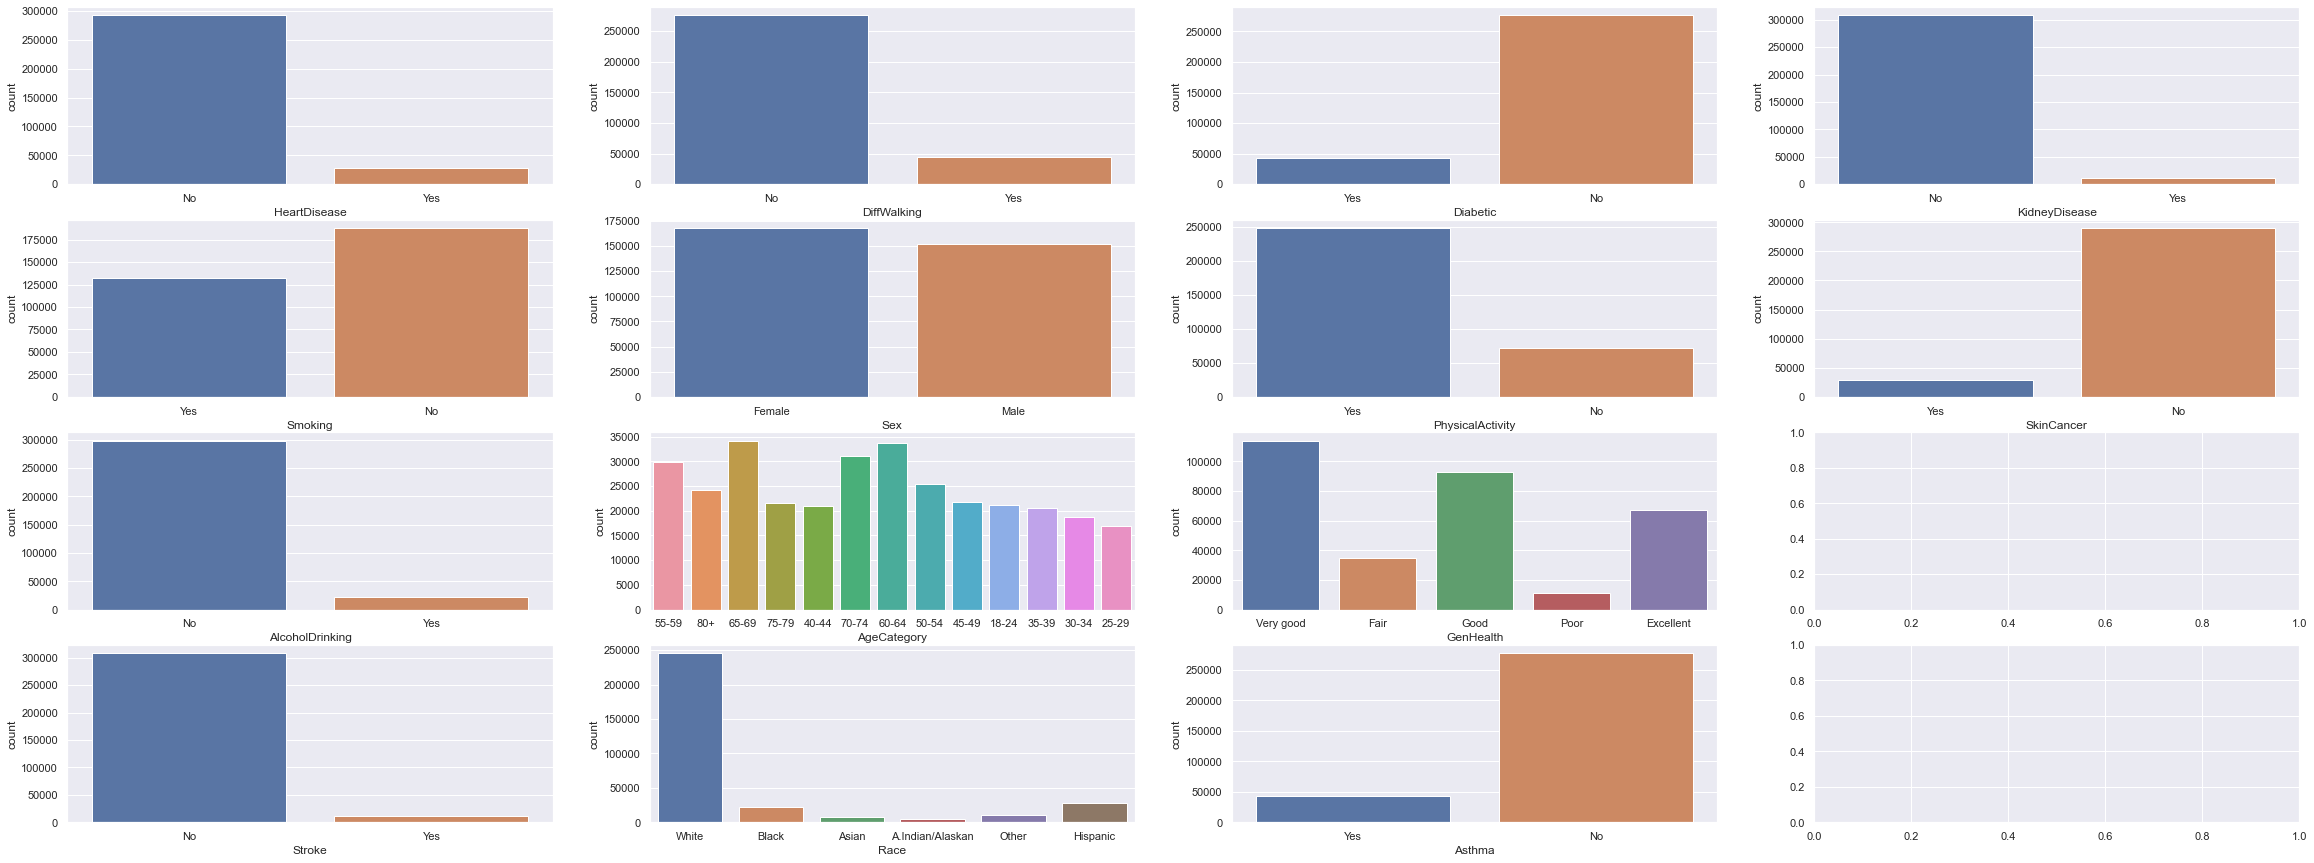

In [6]:
df.loc[df['Diabetic'] == 'No, borderline diabetes', 'Diabetic'] = 'No'
df.loc[df['Diabetic'] == 'Yes (during pregnancy)', 'Diabetic'] = 'Yes'
df.loc[df['AgeCategory'] == '80 or older', 'AgeCategory'] = '80+'
df.loc[df['Race'] == 'American Indian/Alaskan Native', 'Race'] = 'A.Indian/Alaskan'


fig, axs = plt.subplots(4, 4, figsize=(40, 15))
numerical = df.select_dtypes(include=np.number)
i, j = 0, 0

for trait in df.columns:
    if trait not in numerical:
        if i == 4:
            i = 0
            j += 1

        sns.countplot(ax = axs[i][j], data=df, x=trait)
        i += 1

plt.show()


<AxesSubplot:xlabel='AgeCategory', ylabel='count'>

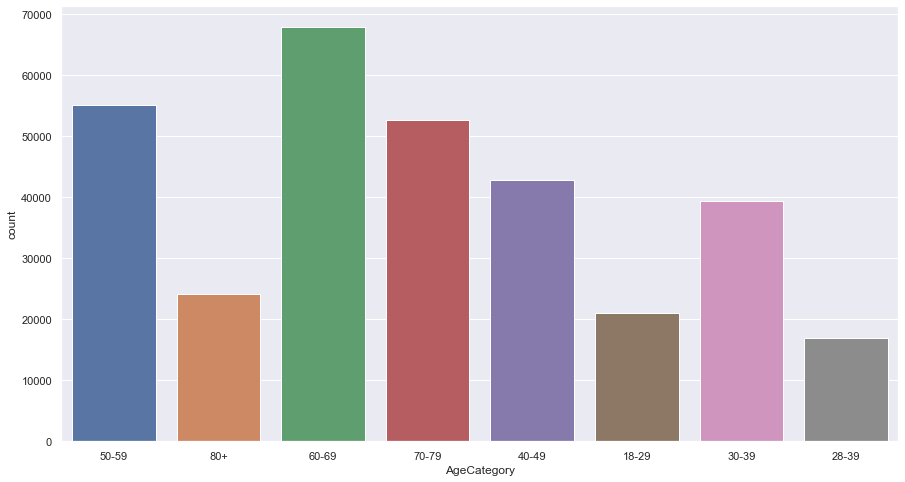

In [7]:
for i in range(1, 8):
    if i == 1 or i == 2:
       df.loc[(df['AgeCategory'].str)[0] == str(i), 'AgeCategory'] = f'{i}8-{i+1}9'
    else: 
        df.loc[(df['AgeCategory'].str)[0] == str(i), 'AgeCategory'] = f'{i}0-{i}9'  

fig, axs = plt.subplots(figsize=(15, 8))
sns.countplot(ax = axs, data=df, x='AgeCategory')

In [8]:
import warnings
warnings.filterwarnings("ignore")

## Our target - make classification, if person has skin cancer or not
#### Of course, we would like to also compare diffrent classifiers, transformers etc.

In [9]:
Y = df['SkinCancer']
X = df.drop(['SkinCancer'], axis=1)

x_train, x_test, y_train, y_test = train_test_split(X, Y, train_size=0.8, stratify=Y, random_state=67)

preprocessing = ColumnTransformer([('categorical', OneHotEncoder(drop="first"), make_column_selector(dtype_exclude=np.number)),
                                         ('continous', StandardScaler(), make_column_selector(dtype_include=np.number))])

clfs = [XGBClassifier(), CatBoostClassifier(silent=True), RandomForestClassifier(),
       LogisticRegression(), DecisionTreeClassifier()]

scalers = [MinMaxScaler(), StandardScaler(), Normalizer()]
categorical_transformers = [OrdinalEncoder(), OneHotEncoder(drop="first")]


In [10]:
classifiers_df = pd.DataFrame(columns=['Classifier', 'Scaler', 'Categorical transformer', 'score'])
inx = 0

column_transformer = Pipeline(steps=[
    ("column_transforms", preprocessing)])

main_pipeline = Pipeline(steps=[
    ('preprocessing', column_transformer),
    ('clf', None)
])

for model in clfs:
    for sr in scalers:
        for cat_tran in categorical_transformers:

            sett_dict = {
                'preprocessing__column_transforms__categorical': cat_tran,
                'preprocessing__column_transforms__continous': sr,
                'clf': model

            }

            main_pipeline.set_params(**sett_dict)
            main_pipeline.fit(x_train, y_train)
            score = main_pipeline.score(x_test, y_test)

            current_model = pd.DataFrame([[model.__class__.__name__, sr.__class__.__name__, cat_tran.__class__.__name__, score]], columns=['Classifier', 'Scaler', 'Categorical transformer', 'score'])
        
            classifiers_df = pd.concat([classifiers_df, current_model])

            print(inx)

            inx += 1



[20:27:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0
[20:27:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
1
[20:27:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
2
[20:27:54] WARNING: C:/Users/Administrator/workspace/xgboost-win

In [11]:
classifiers_df

,Classifier,Scaler,Categorical transformer,score
0,XGBClassifier,MinMaxScaler,OrdinalEncoder,0.906299
0,XGBClassifier,MinMaxScaler,OneHotEncoder,0.906362
0,XGBClassifier,StandardScaler,OrdinalEncoder,0.906299
0,XGBClassifier,StandardScaler,OneHotEncoder,0.906362
0,XGBClassifier,Normalizer,OrdinalEncoder,0.906143
0,XGBClassifier,Normalizer,OneHotEncoder,0.906159
0,CatBoostClassifier,MinMaxScaler,OrdinalEncoder,0.906018
0,CatBoostClassifier,MinMaxScaler,OneHotEncoder,0.905971
0,CatBoostClassifier,StandardScaler,OrdinalEncoder,0.90594
0,CatBoostClassifier,StandardScaler,OneHotEncoder,0.906065


In [17]:
classifiers_df.groupby("Classifier").mean()


,score
Classifier,
CatBoostClassifier,0.905987
DecisionTreeClassifier,0.846555
LogisticRegression,0.906761
RandomForestClassifier,0.886453
XGBClassifier,0.906271
